In [1]:
from readers import PopulationReader
from caches import LFUCache
from cachesim.tools import PBarMixIn
from cachesim import Status
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
count = 1000000
cbase = count // 10


def hns(n: int, s: float) -> float:
    return sum([k ** -s for k in range(1, n + 1)])


def pmf(k: int, s: float, n: int):
    return k ** -s / hns(n, s)


def cdf(k: int, s: float, n: int):
    return hns(k, s) / hns(n, s)


print("Create population...")
s = 1.3
HNs = hns(cbase, s)
reader = PopulationReader(count, cbase, weights=[k ** -s / HNs for k in range(1, cbase + 1)])

Create population...


In [3]:
sizer = 0.1


class MyCache(PBarMixIn, LFUCache):
    pass


cache = MyCache(totalsize=cbase * sizer)

req = list(cache.map(reader))

MyCache: 100%|██████████| 1000000/1000000 [00:02<00:00, 417457.04it/s]


In [4]:
hit = sum(map(lambda r: r.status == Status.HIT, req))
print(f"Requests: {len(req)}")
print(f"CHR: {hit / len(req) * 100:.2f}% (expected: {hns(int(cbase * sizer), s) / hns(cbase, s) * 100:.2f}%)")
print(f"Bytes sent: {sum(r.size for r in req)} B")

x = [r.time for r in req]

Requests: 1000000
CHR: 95.65% (expected: 97.26%)
Bytes sent: 1000000 B


90000/3: 100%|██████████| 3000000/3000000 [00:06<00:00, 434217.76it/s]


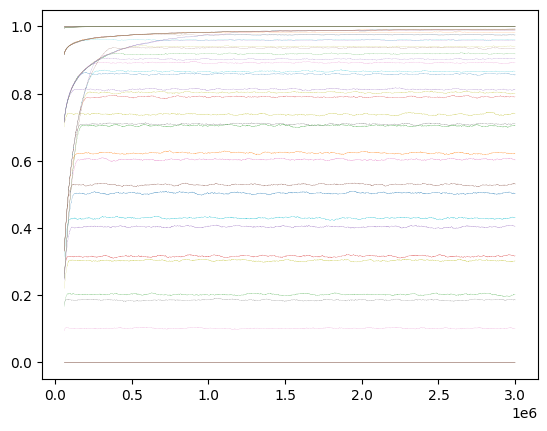

In [171]:
df = pd.DataFrame(columns=['cbase', 's', 'sizer', 'chr'])

count = 3000000  # number oc lient requests
cbase = count // 30  # number of contents

for totalsize in np.arange(0, cbase, cbase // 10, dtype=int):
    for s in [0.1, 0.5, 1, 1.3, 2, 3]:
        HNs = hns(cbase, s)
        reader = PopulationReader(count, cbase, weights=[k ** -s / HNs for k in range(1, cbase + 1)])
        cache = MyCache(totalsize=totalsize, desc=f"{totalsize}/{s}")
        req, age = zip(*list(cache.map(reader)))

        #        hit = sum(map(lambda r: r.status == Status.HIT, req_stable))
        rwin = len(req) // 50
        hits = pd.Series(list(map(lambda r: 1/rwin if r.status == Status.HIT else 0, req)))
        rhits = hits.rolling(rwin).sum()
        rhits.plot(label=f"{totalsize}/{s}", lw=0.1)

        df.loc[len(df)] = [cbase, s, totalsize / cbase, rhits[len(rhits)-1]]

df.set_index(['cbase', 's', 'sizer'], inplace=True)
plt.show()


In [172]:
df.unstack(level=['cbase', 's'])

chr                                                  
cbase  100000.0                                                  
s           0.1       0.5       1.0       1.3       2.0       3.0
sizer                                                            
0.0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
0.1    0.101433  0.185450  0.739300  0.959467  0.999533  0.999950
0.2    0.202150  0.316850  0.812300  0.974183  0.999667  1.000000
0.3    0.301767  0.430250  0.855533  0.982367  0.999667  1.000000
0.4    0.405083  0.530183  0.892183  0.986383  0.999533  1.000000
0.5    0.503350  0.620667  0.917900  0.990100  0.999500  1.000000
0.6    0.602200  0.709550  0.940200  0.991733  0.999633  0.999983
0.7    0.704450  0.790183  0.958467  0.991983  0.999517  0.999950
0.8    0.799833  0.866683  0.974667  0.991667  0.999550  0.999933
0.9    0.903883  0.933467  0.987567  0.992033  0.999600  0.999983

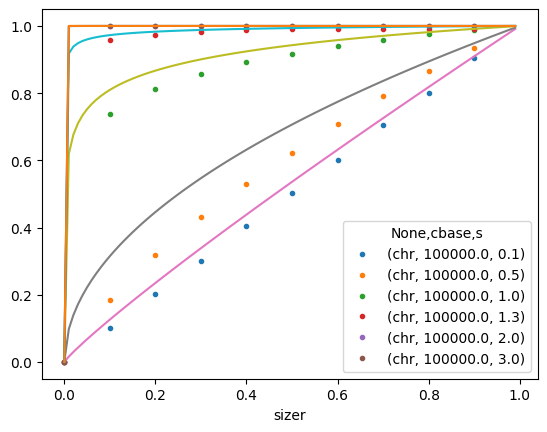

In [174]:
dfu = df.unstack(level=['cbase', 's'])

fig, ax = plt.subplots()
dfu.plot(ax=ax, marker=".", linestyle='None')
for name, cbase, s in dfu.columns.values:
    x = np.arange(0, 1, 1 / 100)
    y = list(map(lambda k: cdf(int(k * cbase), s, int(cbase)), x))
    ax.plot(x, y)


chr
cbase    s   sizer          
100000.0 0.1 0.0    0.000000
         0.5 0.0    0.000000
         1.0 0.0    0.000000
         1.3 0.0    0.000000
         2.0 0.0    0.000000
         3.0 0.0    0.000000
         0.1 0.1    0.101777
         0.5 0.1    0.182357
         1.0 0.1    0.738017
         1.3 0.1    0.959727
         2.0 0.1    0.999617
         3.0 0.1    0.999977
         0.1 0.2    0.202620
         0.5 0.2    0.315637
         1.0 0.2    0.813130
         1.3 0.2    0.974590
         2.0 0.2    0.999580
         3.0 0.2    0.999973
         0.1 0.3    0.304230
         0.5 0.3    0.427490
         1.0 0.3    0.857007
         1.3 0.3    0.982443
         2.0 0.3    0.999580
         3.0 0.3    0.999983
         0.1 0.4    0.403883
         0.5 0.4    0.529683
         1.0 0.4    0.892100
         1.3 0.4    0.986993
         2.0 0.4    0.999640
         3.0 0.4    0.999973

Check the zipf generation

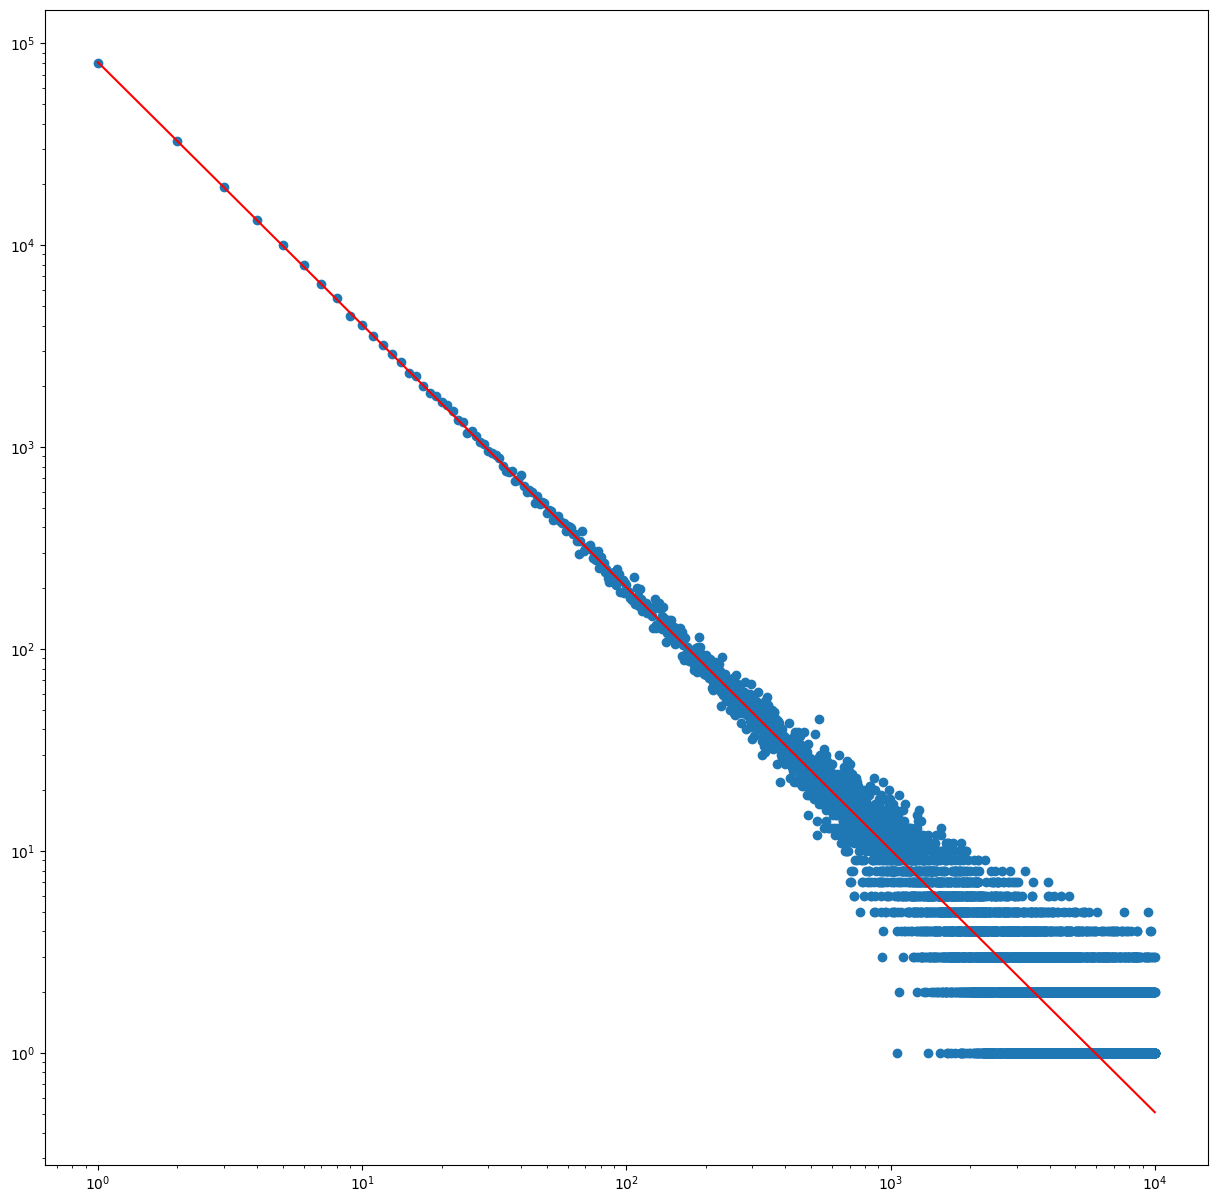

In [18]:
count = 300000  # number of client requests
cbase = count // 30  # number of contents
s = 1.3

reader = PopulationReader(count, cbase, weights=[k ** -s / HNs for k in range(1, cbase + 1)])
values, counts = np.unique(list(map(lambda r: r.hash, reader)), return_counts=True)

fig, ax = plt.subplots(figsize = (15, 15))
ax.scatter(x=values+1, y=counts )
ax.plot(range(1, cbase + 1), list(map(lambda k: count * pmf(k,s,cbase), range(1, cbase + 1))), 'r-')
ax.set_xscale("log")
ax.set_yscale("log")